<a href="https://colab.research.google.com/github/anikch/paddy/blob/main/paddy_doctor_3_EfficientNetB4_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EfficientNetV2L (https://arxiv.org/pdf/2104.00298v2.pdf)

In [1]:
!pip install tensorflow_addons
#!pip install tensorflow_datasets --user
#!pip install tensorflow_hub
#!pip install tensorflow==2.9.0 --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
#import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
#import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import posixpath

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!nvidia-smi

Wed Jul 13 04:28:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:

colab= '/content/drive/MyDrive'
local= r'G:\My Drive'

code_runtime= colab


In [6]:
tf.__version__

'2.8.2'

In [7]:
file1= 'thesis/dataset/paddy_doctor/train.csv'
inp_file = posixpath.join(code_runtime, file1)

train_table=pd.read_csv(inp_file)
train_table

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [8]:
labels=list(np.unique(train_table['label']))
labels

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [9]:
file2= 'thesis/dataset/paddy_doctor/train_images/'
img_files= posixpath.join(code_runtime, file2)

train_data= tf.keras.utils.image_dataset_from_directory(img_files,
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        class_names=labels,
                                                        color_mode='rgb',
                                                        image_size=(224,224),
                                                        shuffle=True,
                                                        validation_split= 0.1,
                                                        subset='training',
                                                        batch_size= 16,
                                                        seed= 101)

val_data= tf.keras.utils.image_dataset_from_directory(img_files,
                                                        labels= 'inferred',
                                                        label_mode='categorical',
                                                        class_names= labels,
                                                        color_mode='rgb',
                                                        image_size=(224,224),
                                                        shuffle=True,
                                                        validation_split= 0.1,
                                                        subset='validation',
                                                        batch_size= 16,
                                                        seed= 101)

Found 10407 files belonging to 10 classes.
Using 9367 files for training.
Found 10407 files belonging to 10 classes.
Using 1040 files for validation.


In [10]:
# Creating data augmentation layer

augmentation_layer= keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2)
])

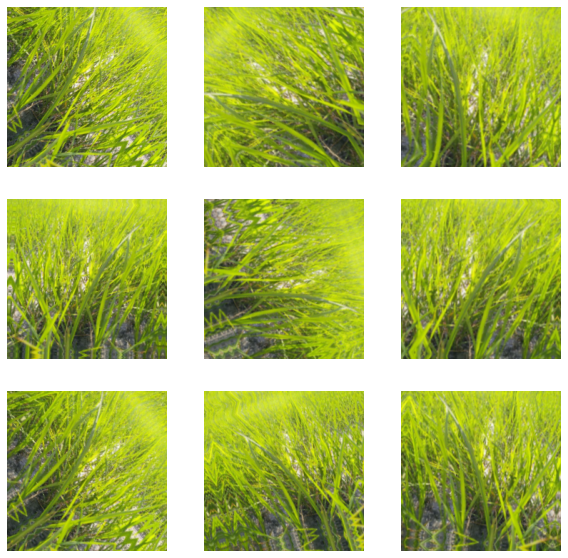

In [13]:
# Checking augmentation

plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
  for i in range(9):
    augmented_images = augmentation_layer(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[9].numpy().astype("uint8"))
    plt.axis("off")

In [14]:
augmented_train_data= train_data.map(
  lambda x, y: (augmentation_layer(x), y))

In [15]:
augmented_train_data

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
augmented_train_data= augmented_train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data= val_data.cache().prefetch(buffer_size=AUTOTUNE)

## Modeling

The preprocessing logic has been included in the EfficientNetV2 model implementation. Users are no longer required to call this method to normalize the input data. This method does nothing and only kept as a placeholder to align the API surface between old and new version of model.

In [17]:
conv_base = tf.keras.applications.efficientnet.EfficientNetB4(include_top = False,  weights = 'imagenet')
conv_base.trainable= False

71696384/71686520 [==============================] - 0s 0us/step


In [16]:
for layer in conv_base.layers:
      if layer.name.startswith('block7') | layer.name.startswith('block6') | layer.name.startswith('block5') | layer.name.startswith('block4') | layer.name.startswith('block3') | layer.name.startswith('block2'):
        if not isinstance(layer, layers.BatchNormalization):
          layer.trainable = True

In [17]:
for l in conv_base.layers:
    print(l.name, l.trainable)


input_1 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv True
block2a_expand_bn False
block2a_expand_activation True
block2a_dwconv_pad True
block2a_dwconv True
block2a_bn False
block2a_activation True
block2a_se_squeeze True
block2a_se_reshape True
block2a_se_reduce True
block2a_se_expand True
block2a_se_excite True
block2a_project_conv True
block2a_project_bn False
block2b_expand_conv True
block2b_e

The BathcNormalization layers need to be kept frozen (more details). If they are also turned to trainable, the first epoch after unfreezing will significantly reduce accuracy.

In [18]:
def create_model(n_classes):
    inputs= layers.Input(shape = (224, 224, 3))
    conv_base = tf.keras.applications.efficientnet.EfficientNetB4(include_top = False,  input_tensor= inputs, weights = 'imagenet')
    conv_base.trainable= False

    for layer in conv_base.layers:
      if layer.name.startswith('block7') | layer.name.startswith('block6') | layer.name.startswith('block5') | layer.name.startswith('block4') | layer.name.startswith('block3') | layer.name.startswith('block2'):
        if not isinstance(layer, layers.BatchNormalization):
          layer.trainable = True

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name = 'GAP')(conv_base.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation = 'softmax', name = 'pred')(x)
    

    # Compile
    BASE_LR = 0.0005
    WEIGHT_DECAY = 0.0001
    BATCH_SIZE= 16
    lr_scaled = (BASE_LR / 512) * BATCH_SIZE
    #optimizer= tfa.optimizers.AdamW(weight_decay=WEIGHT_DECAY, learning_rate=lr_scaled)
    optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-4)
    #scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    model = tf.keras.Model(inputs, outputs, name = 'EfficientNetB4_finetuned')
    model.compile(
        optimizer = optimizer,
        loss = 'categorical_crossentropy', 
        metrics = ['accuracy', tfa.metrics.F1Score(average='macro', num_classes= 10)]
        )
    
    return model

model= create_model(10)

In [21]:
model.summary()

Model: "EfficientNetB4_finetuned"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                           

In [19]:
n_epochs = 50

In [20]:
print(f"Number of parameters (millions): {model.count_params() / 1e6}.")

Number of parameters (millions): 17.698921.


In [22]:

%%time

filepath= "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint_callback= ModelCheckpoint(filepath, monitor= 'val_accuracy', verbose= 1, save_best_only =True, mode= 'max')
early_stop_callback= EarlyStopping(monitor='val_accuracy', patience= 15, verbose=False, mode='max')
callbacks_list=[checkpoint_callback]

history= model.fit(augmented_train_data,
                    epochs= n_epochs,
                    validation_data= val_data,
                    callbacks=callbacks_list,
                    verbose= 1)

Epoch 1/50
586/586 [==============================] - ETA: 0s - loss: 1.3543 - accuracy: 0.5533 - f1_score: 0.4705
Epoch 1: val_accuracy improved from -inf to 0.68077, saving model to weights-improvement-01-0.68.hdf5
586/586 [==============================] - 427s 678ms/step - loss: 1.3543 - accuracy: 0.5533 - f1_score: 0.4705 - val_loss: 0.9108 - val_accuracy: 0.6808 - val_f1_score: 0.5997
Epoch 2/50
586/586 [==============================] - ETA: 0s - loss: 0.6420 - accuracy: 0.7879 - f1_score: 0.7484
Epoch 2: val_accuracy improved from 0.68077 to 0.81923, saving model to weights-improvement-02-0.82.hdf5
586/586 [==============================] - 142s 243ms/step - loss: 0.6420 - accuracy: 0.7879 - f1_score: 0.7484 - val_loss: 0.5463 - val_accuracy: 0.8192 - val_f1_score: 0.7700
Epoch 3/50
586/586 [==============================] - ETA: 0s - loss: 0.3317 - accuracy: 0.8912 - f1_score: 0.8755
Epoch 3: val_accuracy did not improve from 0.81923
586/586 [==============================] - 

In [23]:
model.load_weights('/content/weights-improvement-35-0.94.hdf5')

In [24]:
model_file= 'thesis/dataset/paddy_doctor/paddy_doctor_3_EfficientNetB4-TF'
model_loc= posixpath.join(code_runtime, model_file)
model.save(model_loc)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/thesis/dataset/paddy_doctor/paddy_doctor_3_EfficientNetB4-TF/assets


In [25]:
import json
with open('/content/drive/MyDrive/thesis/dataset/paddy_doctor/paddy_doctor_3_EfficientNetB4-TF/history.json', 'w') as f:
    json.dump(history.history, f)

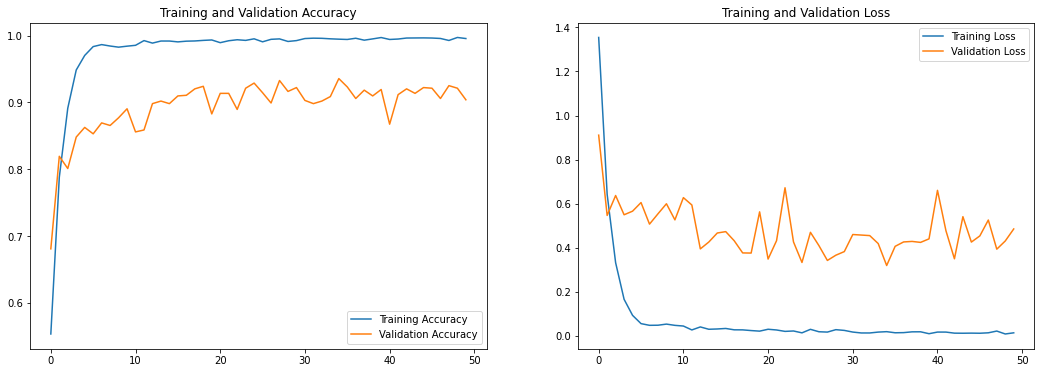

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/thesis/dataset/paddy_doctor/paddy_doctor0")

In [ ]:
model.summary()